# Looking for correlations between rednoise amplitude and Rossby Number


In [12]:
from extras import *

In [13]:
prefix = '/Users/mcantiello/Dropbox (Personal)/work/transtar21/Atlas/grid/' # Using our mighty Atlas! 
DIR = prefix+'runs/' # The directory where you unpacked the data
mods = [5.0 ,6.0 ,7.0, 8.0, 9.0 ,10 ,12, 14 ,16 ,18 ,20 ,22, 24, 26, 28, 30, 40, 50, 60, 70, 80 ,90 ,100, 120]
hrdlines = [5.0,7.0,10,20,30,40,60,100,120]

### Uncomment next cell to load/save data from model grid with pickle

In [14]:
#hs = list(mr.MesaData(DIR+str(j)+'/LOGS/history.data') for j in mods)
#pickle.dump([prefix,DIR,mods,hs,hrdlines],open('parsed.data','wb'))

In [15]:
prefix,DIR,mods,hs,hrdlines = pickle.load(open('parsed.data','rb'))

#### Step 1 - Create the Tau_c_core map for models in the grid (from the ATLAS)
#### Step 2 - From the interpolated map, extract values corresponding to (Teff_LogL pairs)
#### Step 3 - Use vsini to calculate Ro for each star
#### Step 4 - Plot alpha vs Ro/sini  

<ipython-input-29-2e9e0dfe54a5>:53: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-29-2e9e0dfe54a5>:54: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")


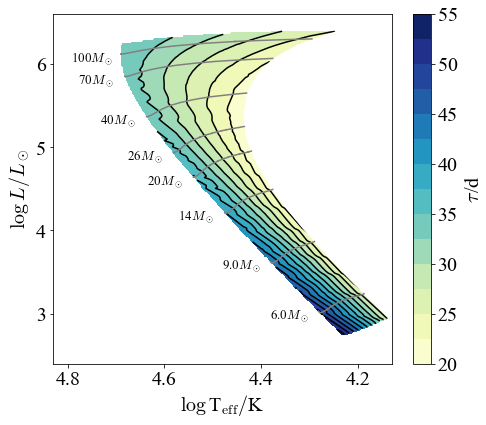

In [29]:
x = []
y = []
z = []
k = 0
lzams = []
tzams = []
gzams = []
mask_beyond_tams=[]
    
for i in range(0,len(mods)):
      h=hs[i]

      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
    
      ell = logl
    
      zams=find_h(0.001,center_h1,model)
      tams=find_tams(center_h1,model)
        
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:tams])
      y.append(ell[zams:tams])
      z.append(h.turnover_core[zams:tams]/24/3600)
      mask_beyond_tams.append([logt[tams],ell[tams]]) # To patch region of interpolation outside tams
     
x=array(list(flatten(x)))
y=array(list(flatten(y)))
z=array(list(flatten(z)))


fig = plt.figure()
ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])

numcols, numrows = 200, 200
xi = np.linspace(x.min(), x.max(), numcols)
yi = np.linspace(y.min(), y.max(), numrows)

#Interpolate convective turnover time
triang = tri.Triangulation(x,y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")

fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\tau_{\rm}$/d')
plt.gca().invert_xaxis()


dt = 0.06
dl = -0.09


for i in range(1,len(mods),3):
    h=hs[i]    
    model = h.model_number 
    logl = h.log_L
    logg = h.log_g 
    center_h1 = h.center_h1 
    logt= h.log_Teff 
    zams=find_h(0.001,center_h1,model)
    tams=find_tams(center_h1,model)
    ell = (10**logt)**4.0/(10**logg)
    ell=np.log10(ell/ell_sun)  
    ell = logl
    plt.plot(logt[zams:tams],ell[zams:tams],c='gray',alpha=1.0)
    ax.text(logt[zams]+dt,ell[zams]+dl,str(mods[i])+r'$M_\odot$',ha='center',fontsize=13) # ,verticalalignment='center',rotation='vertical',  
          
   
# Patch contour region outside TAMS
patches = []   
polygon = matplotlib.patches.Polygon(mask_beyond_tams, closed=True,fill=True, color='white')
patches.append(polygon)
coll = PatchCollection(patches, zorder=2,color='white')
ax.add_collection(coll) 

ax.set_xlabel(lgteff)
ax.set_ylabel(lgl)
ax.set_xlim([4.83,4.13])
ax.set_ylim([2.4,6.6])

plt.savefig("turnover_core.pdf",bbox_inches='tight')

## Here's the data from Bowman et al. 2020

In [21]:
DIR = './'
file1='bowman_tablea1.txt'
file2='bowman_tablea2.txt'
file3='bowman2022_tableB1.csv'

df1 = pd.read_csv(file1, 
                 sep="|", 
                 skiprows=6, 
                 skipfooter = 1,
                 usecols=[2,4,5,6,7], 
                 names=['TIC','LogT','LogL','vsini','vmacro'])


df2 = pd.read_csv(file2, 
                 sep="|", 
                 skiprows=6, 
                 skipfooter = 1, 
                 usecols=[2,3,4], 
                 names=['TIC','alpha0','nuchar'])

df3 = pd.read_csv(file3, 
                 sep=",", 
                 skiprows=1, 
                 skipfooter = 1, 
                 usecols=[1,2,4,5,6,7,8,9], 
                 names=['TIC','nuchar_20','nuchar_22','err_p','err_m','sigma','sigma_p','sigma_m'])

nuchar=df2['nuchar']
alpha0=df2['alpha0']
vsini=df1['vsini']
vmacro=df1['vmacro']
LogT=df1['LogT']
LogL=df1['LogL']

nuchar = [float(item) for item in nuchar]
alpha0 = [float(item) for item in alpha0]
vsini = [float(item) for item in vsini]
LogT = [float(item) for item in LogT]
LogL = [float(item) for item in LogL]
#vmacro = [float(item) for item in vmacro]

print (df1)
print (df2)
print (df3)

          TIC  LogT  LogL  vsini vmacro
0   306491594  4.66  4.10     59     86
1   234881667  4.62  4.16     60     91
2   216662610  4.63  3.88    278    ---
3   234840662  4.61  4.03     71     94
4   464295672  4.59  3.95     55     55
..        ...   ...   ...    ...    ...
65  102281507  4.11  2.34     26     28
66  427393920  4.49  3.07    210    ---
67   11360636  4.47  4.15    122     97
68  187458882  4.54  3.62     12     38
69  177860391  4.52  3.16      7     10

[70 rows x 5 columns]
          TIC   alpha0  nuchar
0   306491594   99.219   0.039
1   234881667  249.330   0.047
2   216662610  253.521   0.033
3   234840662  175.470   0.044
4   464295672  186.796   0.051
..        ...      ...     ...
65  102281507    8.600   0.081
66  427393920   34.886   0.068
67   11360636  829.560   0.070
68  187458882  159.073   0.095
69  177860391   32.960   0.052

[70 rows x 3 columns]
          TIC  nuchar_20  nuchar_22  err_p  err_m    sigma  sigma_p  sigma_m
0   306491594    5.74308 

<ipython-input-21-115297cdae1a>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df1 = pd.read_csv(file1,
<ipython-input-21-115297cdae1a>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df2 = pd.read_csv(file2,
<ipython-input-21-115297cdae1a>:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df3 = pd.read_csv(file3,


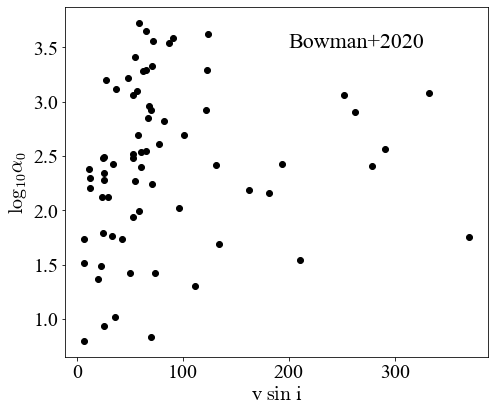

In [22]:
fig = plt.figure()
ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
ax.scatter(vsini,np.log10(alpha0),color=BLACK)
ax.set_ylabel(r'$\log_{10} \alpha_0$')
ax.set_xlabel(r'v $\sin$ i')
ax.text(200,3.5,'Bowman+2020',fontsize=22)
plt.savefig("rednoise_vsini.pdf",bbox_inches='tight')

In [23]:
x = []
y = []
z = []
zz = []

k = 0
lzams = []
tzams = []
gzams = []
mask_beyond_tams=[]

for i in range(0,len(mods)):
  h=hs[i]
  model = h.model_number 
  logl = h.log_L   
  center_h1 = h.center_h1 
  logg = h.log_g   
  logt= h.log_Teff 
  ell = (10**logt)**4.0/(10**logg)
  ell=np.log10(ell/ell_sun)  

  zams=find_h(0.001,center_h1,model)
  tams=find_tams(center_h1,model)  

  # Create Lists  
  lzams.append(ell[zams])
  gzams.append(logg[zams])
  tzams.append(ell[zams])
  x.append(logt[zams:tams])
  y.append(ell[zams:tams])
  # z.append(h.Core_turnover_time[zams:]/24/3600)
  z.append(h.turnover_core[zams:tams]/24/3600)
  zz.append(10**h.log_R[zams:tams])
  mask_beyond_tams.append([logt[tams],ell[tams]]) # To patch region of interpolation outside tams  

x=array(list(flatten(x)))
y=array(list(flatten(y)))
z=array(list(flatten(z)))
zz = array(list(flatten(zz)))

numcols, numrows = 200, 200
xi = np.linspace(x.min(), x.max(), numcols)
yi = np.linspace(y.min(), y.max(), numrows)


70
[16.4914064153619 21.81518356045361 10.861221552784308 15.663913410444238
 13.92888154516642 7.482299539312805 9.036545846628734 10.240467790398142
 12.998050444092172 14.640220441797638 10.938129565695178
 8.139502932989522 8.783218079423207 14.792553131605715 17.83059914929089
 12.638414824636527 -- 11.664247732992138 23.769024739946882
 24.51012454587071 12.259085914467931 20.33669250049003 14.945197071912219
 17.84894292869214 15.91335732687486 15.91335732687486 25.31790753447764
 35.55071221309319 31.31322751906262 -- 63.146842452195735
 20.752263797793972 32.495005526292715 32.75375792213987 54.31807539479753
 30.888094430685072 24.95902463440686 7.215300666960502 4.850422544486243
 5.123965214848646 4.3213500061548515 5.6788677569103 6.336077857240468
 8.569405193683068 9.706807063918589 5.122339957326872 4.321699846214564
 15.976655193943543 11.625034537470356 -- 6.1413494422651524 --
 19.49220445858515 6.600704914499701 15.614821409199521 8.574642849441219
 111.597825322405

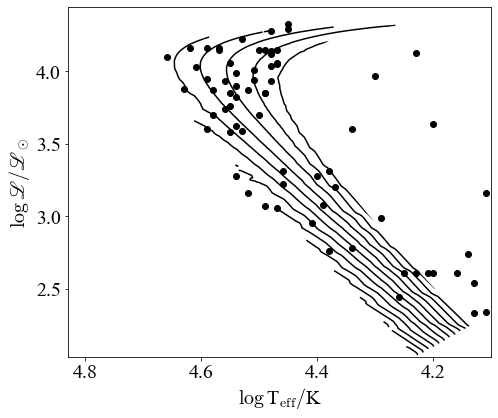

In [24]:
#Interpolate convective turnover time
triang = tri.Triangulation(x,y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# Interpolate radii
interpolator_r = tri.LinearTriInterpolator(triang, zz)


fig = plt.figure()
ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
ax.contour(xi, yi, zi, 14, colors='k')

# Patch contour region outside TAMS
patches = []   
polygon = matplotlib.patches.Polygon(mask_beyond_tams, closed=True,fill=True, color='white')
patches.append(polygon)
coll = PatchCollection(patches, zorder=2,color='white')
ax.add_collection(coll) 
    
ax.scatter(LogT,LogL,color=BLACK,zorder=3)

ax.set_xlabel(lgteff)
ax.set_ylabel(lgell)
ax.set_xlim([4.83,4.1])


i_turnover=interpolator(LogT,LogL)
i_radii = interpolator_r(LogT,LogL)

print(len(i_turnover))

print(i_radii)

# Copy Mask
mask=i_radii.mask

# Remove Masked elements (these are elements out of the interpolation range)
i_turnover = np.array(i_turnover[~i_turnover.mask])
i_radii = np.array(i_radii[~i_radii.mask])

# Remove elements for which we don't have interpolated values for radii and turnover
# First apply mask, then remove masked elemeents
i_vsini = np.ma.masked_array(vsini, mask=mask)
i_LogL = np.ma.masked_array(LogL, mask=mask)
i_LogT = np.ma.masked_array(LogT, mask=mask)
i_alpha0 = np.ma.masked_array(alpha0, mask=mask)

i_vsini = np.array(i_vsini[~i_vsini.mask])
i_LogL = np.array(i_LogL[~i_LogL.mask])
i_LogT = np.array(i_LogT[~i_LogT.mask])
i_alpha0 = np.array(i_alpha0[~i_alpha0.mask])

i = 0
print(len(i_turnover))
for i in range(0,len(i_turnover)-1):
    print(i_LogL[i],i_LogT[i],i_turnover[i],i_radii[i],i_alpha0[i])
    

#### Note we discarded 10 stars (using 60/70) because they are beyond the main sequence (so can't really define a core Ro for those)

## Calculate Rossby Numbers

In [25]:
rot_period = 2.0*3.1415*i_radii*rsun/(i_vsini*1e5)
rossby = rot_period/(i_turnover*24*3600)

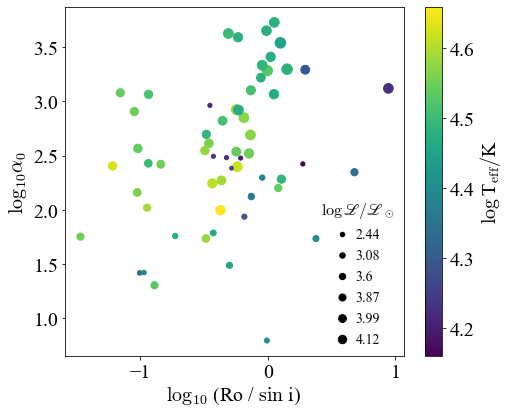

In [26]:
fig = plt.figure()
ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
#ax.scatter(np.log10(rossby),np.log10(i_alpha0),s=3.0**i_LogL,c=i_LogT, cmap='viridis')



sizes = [3**i for i in i_LogL]  # Get unique values of i_LogL and compute corresponding marker sizes
sc = ax.scatter(np.log10(rossby), np.log10(i_alpha0), s=sizes, c=i_LogT, cmap='viridis')
handles, labels = sc.legend_elements("sizes")

# Get five representative i_LogL values to display in the legend
unique_i_LogL = np.unique(i_LogL)
step = max(int(len(unique_i_LogL) / 6), 1)  # Compute step size for selecting representative values
selected_i_LogL = unique_i_LogL[::step][:6]

labels = [f'{i}' for i in selected_i_LogL]  # Create custom legend labels with selected i_LogL values
legend1 = ax.legend(handles, labels, loc='lower right', title=lgell)

# Add legend for color map
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(i_LogT)
cbar = plt.colorbar(sm)
cbar.set_label(lgteff)


ax.set_ylabel(r'$\log_{10} \alpha_0$')
ax.set_xlabel(r'$\log_{10}$ (Ro / $\sin$ i) ')
plt.savefig("rednoise_Ro.pdf",bbox_inches='tight')